In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plFuns import *
plt.rcParams['figure.figsize']=[32,18]

In [72]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }

In [73]:
all_data=dict()
all_team_names=dict()
for country in urls:
    all_data[country]=pd.read_csv(urls[country],usecols=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])
    all_team_names[country]=set(all_data[country]['HomeTeam']).union(set(all_data[country]['AwayTeam']))

In [74]:
class Team(object):
    def __init__(self, name='team name',country='SH'):
        self.name = name
        self.country=country
        self.lmbd_set = np.linspace(0, 5, 1001)
        self.p = self.lmbd_set * 0 + 1
        self.p = self.p / self.p.sum()
        self.tau_set = np.linspace(0, 5, 1001)
        self.q = self.tau_set * 0 + 1
        self.q = self.q / self.q.sum()

    def simplify(self, threshold=1e-10):
        ind = self.p > threshold
        self.lmbd_set = self.lmbd_set[ind]
        self.p = self.p[ind]
        self.p = self.p / self.p.sum()
        ind = self.q > threshold
        self.tau_set = self.tau_set[ind]
        self.q = self.q[ind]
        self.q = self.q / self.q.sum()

    def __add__(self, other_team, n_scenarios=int(1e4)):
        GH, GA, match_des = self.vs(other_team,n=n_scenarios)
        return np.array([(GH > GA).sum(), (GH == GA).sum(), (GH < GA).sum()]) / n_scenarios

    def vs(self, other_team, n=int(1e4)):
        lH = np.random.choice(self.lmbd_set, size=n, p=self.p) + np.random.choice(other_team.tau_set, size=n,
                                                                                  p=other_team.q)
        gH = np.random.poisson(lH)
        lA = np.random.choice(self.tau_set, size=n, p=self.q) + np.random.choice(other_team.lmbd_set, size=n,
                                                                                 p=other_team.p)
        gA = np.random.poisson(lA)
        match_des = self.name + ' vs ' + other_team.name
        return gH, gA, match_des

    def plt(self):
        plt.plot(self.lmbd_set, self.p, label=self.name + ' lmbda')
        plt.plot(self.tau_set, self.q, label=self.name + ' tau')
        plt.legend()
        plt.grid(True)
        l, t = self.means()
        plt.title('lambda: {:0.2f} tau: {:0.2f}'.format(l, t))

    def means(self):
        return self.p.dot(self.lmbd_set), self.q.dot(self.tau_set)
    
    def scored_against(self,other,k):
        lmb_plus_tau = self.lmbd_set + other.tau_set[:, np.newaxis]
        new_p = ((np.exp(-lmb_plus_tau) * (lmb_plus_tau ** k)).T * other.q).sum(axis=1) * self.p
        self.p = new_p / new_p.sum()
        new_q = ((np.exp(-lmb_plus_tau) * (lmb_plus_tau ** k)) * self.p).sum(axis=1) * other.q
        other.q = new_q / new_q.sum()
    

In [75]:
teams=dict()
for _country in all_team_names:
    _team_names=all_team_names[_country]
    for _team_name in _team_names:
        teams[_team_name]=Team(name=_team_name,country=_country)

In [76]:
for _country in all_data:
    _data=all_data[_country]
    print(_country)
    for index, row in _data.iterrows():
        home_team=teams[row['HomeTeam']]
        away_team=teams[row['AwayTeam']]
        hg=row['FTHG']
        ag=row['FTAG']
        if not (np.isnan(hg) or np.isnan(ag)):
            home_team.scored_against(away_team,hg)
            away_team.scored_against(home_team,ag)
            home_team.simplify()
            away_team.simplify()

EN
ES
IT
FR
DE
NL


In [265]:
def p_plot(x):
    a=x.min()
    b=x.max()
    xx=np.arange(a,b+1)
    yy=xx*0
    for _i in range(xx.shape[0]):
        yy[_i]=(x==xx[_i]).sum()
    yy=100*yy/yy.sum()
    return xx,yy
class Season:
    def __init__(self,teams):
        self.teams=teams
        self.nr_teams=len(teams)
        self.all_matches={home+' v '+away:{'Done':False,'Home':home,'Away':away} for home in teams for away in teams if home!=away }
        self.matches_to_sim=self.all_matches
        self.current_goals=dict()
        self.current_goals_against=dict()
        self.current_points=dict()
        self.simulated_home_goals=None
        self.simulated_away_goals=None
        self.simulated_home_points=None
        self.simulated_away_points=None
        self.team_id=dict()
        i=0
        for _team in teams:
            self.team_id[_team]=i
            self.current_goals[_team]=0
            self.current_goals_against[_team]=0
            self.current_points[_team]=0
            i+=1
        self.simulation_done=False
        self.simulation_processed=False
    
    def process_current_results(self,data):
        for index, row in data.iterrows():
            home_team=row['HomeTeam']
            away_team=row['AwayTeam']
            match=home_team+' v '+away_team
            home_goals=row['FTHG']
            away_goals=row['FTAG']
            if not (np.isnan(home_goals) or np.isnan(away_goals)):
                self.current_goals[home_team]+=home_goals
                self.current_goals[away_team]+=away_goals
                self.current_goals_against[home_team]+=away_goals
                self.current_goals_against[away_team]+=home_goals

                if home_goals>away_goals:
                    self.current_points[home_team]+=3
                elif home_goals<away_goals:
                    self.current_points[away_team]+=3
                else:
                    self.current_points[home_team]+=1
                    self.current_points[away_team]+=1
                self.all_matches[match]['Done'] = True
            self.matches_to_sim={x: self.all_matches[x] for x in  self.all_matches if not self.all_matches[x]['Done']}
            
    
    def simulate_season(self,n_scenarios=10000):
        nr_matches_to_sim=len(self.matches_to_sim)
        self.match_id=dict()
        i=0
        self.simulated_home_goals=np.zeros([nr_matches_to_sim,n_scenarios])
        self.simulated_away_goals=np.zeros([nr_matches_to_sim,n_scenarios])
        for match in self.matches_to_sim:
            self.match_id[match]=i
            home_team=self.teams[self.matches_to_sim[match]['Home']]
            away_team=self.teams[self.matches_to_sim[match]['Away']]
            gH, gA, _ = home_team.vs(away_team,n=n_scenarios)
            self.simulated_home_goals[i,:]=gH
            self.simulated_away_goals[i,:]=gA
            i+=1
        self.simulation_done=True
        self.simulation_processed=False
    
    def what_if(self,match,ref_team='Man United'):
        match_id=self.match_id[match]
        _details=self.matches_to_sim[match]
        _home = _details['Home']
        _away = _details['Away']

        home_goals=self.simulated_home_goals[match_id,:]
        away_goals=self.simulated_away_goals[match_id,:]
        home_won=home_goals>away_goals
        away_won=home_goals<away_goals
        draw=home_goals==away_goals
        ref_team_id=self.team_id[ref_team]
        place_if_home=self.place_per_team[ref_team_id,home_won]
        place_if_away=self.place_per_team[ref_team_id,away_won]
        place_if_draw=self.place_per_team[ref_team_id,draw]
        
        fig,ax=plt.subplots(2,2)
        
        x,y=p_plot(self.place_per_team[ref_team_id])
        p_cl=100*(self.place_per_team[ref_team_id]<=4).sum()/self.place_per_team[ref_team_id].shape[0]
        ax[0,0].bar(x,y)
        ax[0,0].set_xticks(x)
        ax[0,0].set_title('{:s} Place. CL: {:0.2f}'.format(ref_team,p_cl))
        
        x,y=p_plot(place_if_home)
        p_cl=100*(place_if_home<=4).sum()/place_if_home.shape[0]
        ax[0,1].bar(x,y)
        ax[0,1].set_xticks(x)
        ax[0,1].set_title('Place if {:s} Win. CL: {:0.2f}'.format(_home,p_cl))
        
        x,y=p_plot(place_if_away)
        p_cl=100*(place_if_away<=4).sum()/place_if_away.shape[0]
        ax[1,0].bar(x,y)
        ax[1,0].set_title('Place if {:s} Win. CL: {:0.2f}'.format(_away,p_cl))
        
        x,y=p_plot(place_if_draw)
        p_cl=100*(place_if_draw<=4).sum()/place_if_draw.shape[0]
        ax[1,1].bar(x,y)
        ax[1,1].set_title('Place if Draw. CL: {:0.2f}'.format(p_cl))
        
        for _i in ax:
            for _j in _i:
                _j.grid(True)
        
        
        fig.set_size_inches(16,9)
            
    
    def process_simulation(self):
        n_scenarios=self.simulated_home_goals.shape[1]
        points_per_team = np.zeros([self.nr_teams,n_scenarios])
        place_per_team = np.zeros([self.nr_teams,n_scenarios])
        goals_per_team = np.zeros([self.nr_teams,n_scenarios])
        goals_against_per_team = np.zeros([self.nr_teams,n_scenarios])
        
        for _team in self.teams:
            team_id = self.team_id[_team]
            points_per_team[team_id,:]=self.current_points[_team]
            goals_per_team[team_id,:]=self.current_goals[_team]
            goals_against_per_team[team_id,:]=self.current_goals_against[_team]
            
        for _match in self.matches_to_sim:
            _details=self.matches_to_sim[_match]
            _home = _details['Home']
            _home_id=self.team_id[_home]
            _away = _details['Away']
            _away_id=self.team_id[_away]
            match_id = self.match_id[_match]
            home_goals=self.simulated_home_goals[match_id]
            away_goals=self.simulated_away_goals[match_id]
            goals_per_team[_home_id,:]+=home_goals
            goals_per_team[_away_id,:]+=away_goals
            goals_against_per_team[_home_id,:]+=away_goals
            goals_against_per_team[_away_id,:]+=home_goals
            home_won=home_goals>away_goals
            away_won=home_goals<away_goals
            draw=home_goals==away_goals
            points_per_team[_home_id,home_won]+=3
            points_per_team[_home_id,draw]+=1
            points_per_team[_away_id,away_won]+=3
            points_per_team[_away_id,draw]+=1

        modified_points= np.zeros([self.nr_teams,n_scenarios])
        modified_points+=points_per_team
        b=(goals_per_team-goals_against_per_team).max(axis=0)
        a=(goals_per_team-goals_against_per_team).min(axis=0)
        modified_points+=0.1*((goals_per_team-goals_against_per_team)-a)/(b-a)
        b=goals_per_team.max(axis=0)
        a=goals_per_team.min(axis=0)
        modified_points+=0.01*(goals_per_team-a)/(b-a)
        modified_points+=0.001*np.random.random(modified_points.shape)
        place_per_team=0*modified_points
        ordering=(-modified_points).argsort(axis=0)
        for _team_id in range(self.nr_teams):
            a,b=np.where(ordering==_team_id)
            place_per_team[_team_id,b]=a+1
        
        self.place_per_team=place_per_team
        self.points_per_team=points_per_team
        self.goals_per_team=goals_per_team
        self.goals_against_per_team=goals_against_per_team
        self.simulation_processed=True
    
    def team_report(self,team_name):
        if not self.simulation_done:
            print('simulation not yet done, simulating')
            self.simulate_season()
        if not self.simulation_processed:
            print('simulation not yet processed, processing')
            self.process_simulation()
        fig,ax=plt.subplots(2,2)
        x,y=p_plot(self.place_per_team[self.team_id[team_name],:])
        ax[0,0].bar(x,y)
        ax[0,0].set_xticks(x)
        ax[0,0].set_title('Place')
        x,y=p_plot(self.points_per_team[self.team_id[team_name],:])
        ax[0,1].bar(x,y)
        ax[0,1].set_title('Points')
        x,y=p_plot(self.goals_per_team[self.team_id[team_name],:]-self.goals_against_per_team[self.team_id[team_name],:])
        ax[1,0].bar(x,y)
        ax[1,0].set_title('Goal Difference')
        x,y=p_plot(self.goals_per_team[self.team_id[team_name],:])
        ax[1,1].bar(x,y)
        ax[1,1].set_title('Goals')
        
        for _i in ax:
            for _j in _i:
                _j.grid(True)
        
        
        fig.set_size_inches(16,9)

In [266]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

simulation not yet processed, processing


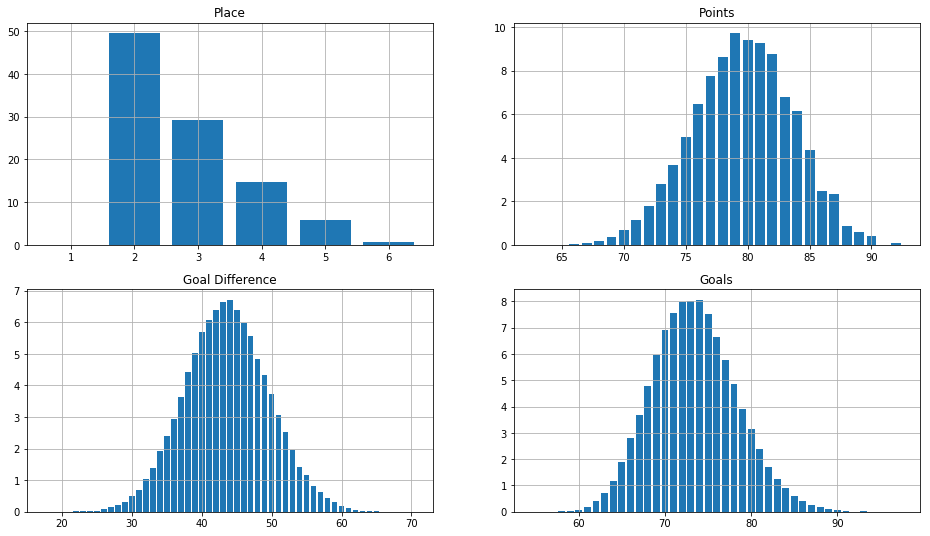

In [267]:
PremierLeague.team_report('Man United')

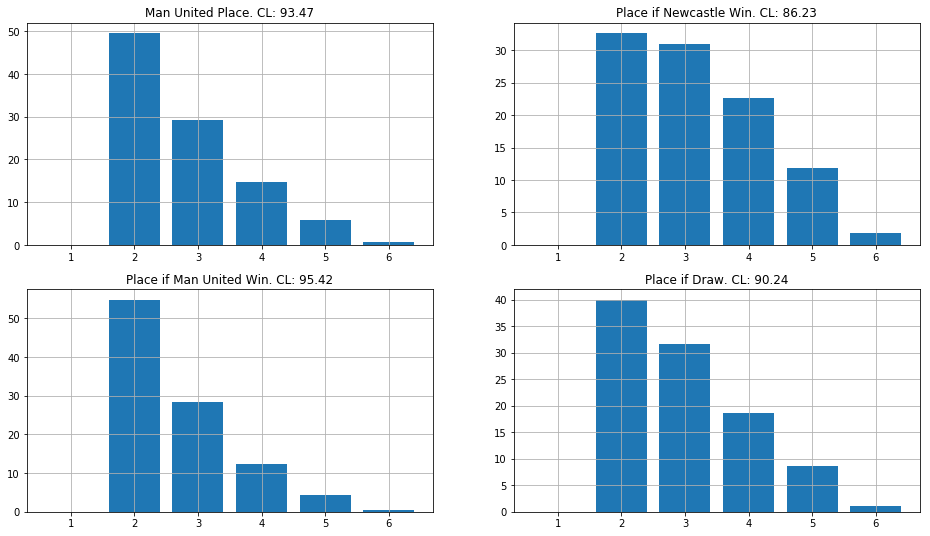

In [273]:
PremierLeague.what_if('Newcastle v Man United')

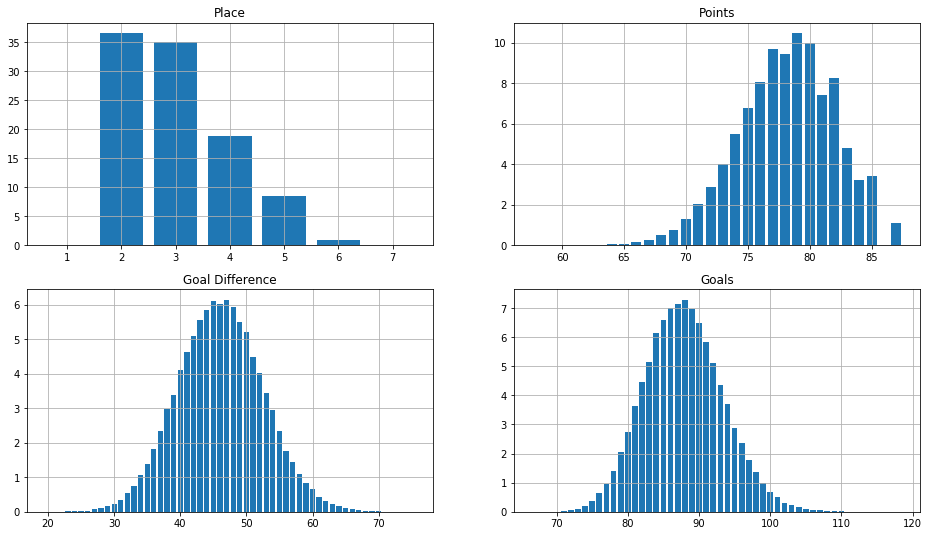

In [240]:
PremierLeague.team_report('Liverpool')

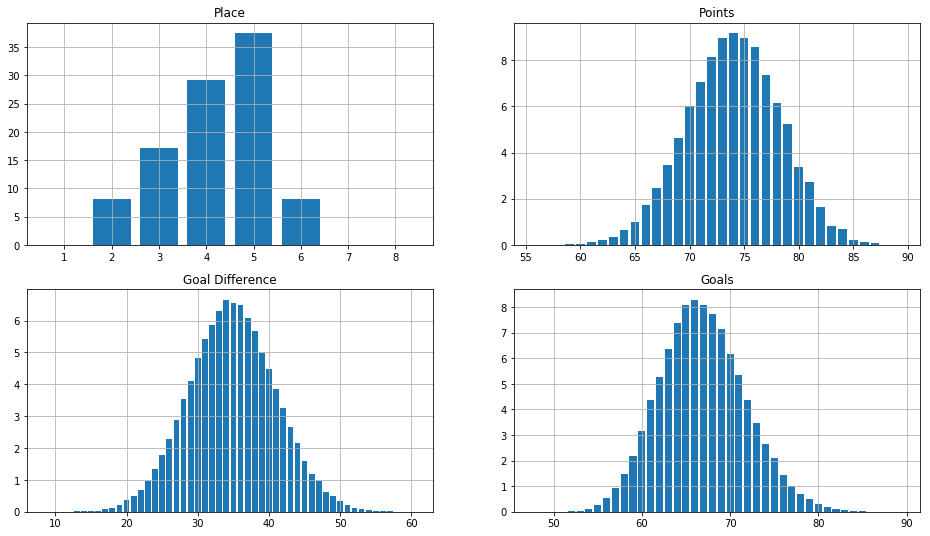

In [241]:
PremierLeague.team_report('Chelsea')

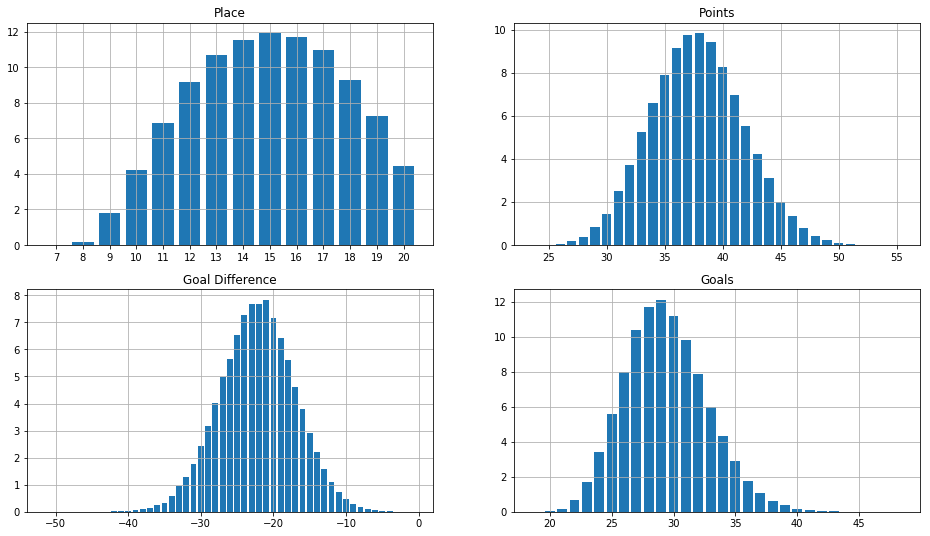

In [206]:
PremierLeague.team_report('Swansea')

In [218]:
GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1 and teams[x].country=='EN'}
GoodTeams={x:teams[x] for x in teams}

In [224]:
GoodLeague=Season(GoodTeams)
GoodLeague.process_current_results(all_data['EN'])
GoodLeague.process_current_results(all_data['ES'])
GoodLeague.process_current_results(all_data['DE'])
GoodLeague.process_current_results(all_data['NL'])
GoodLeague.process_current_results(all_data['FR'])
GoodLeague.process_current_results(all_data['IT'])


simulation not yet done, simulating
simulation not yet processed, processing


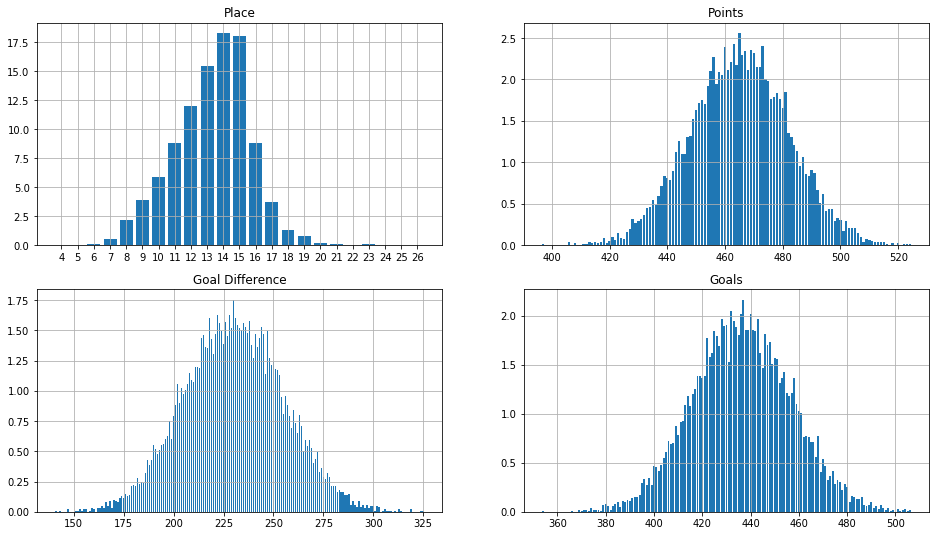

In [225]:
GoodLeague.team_report('Man United')

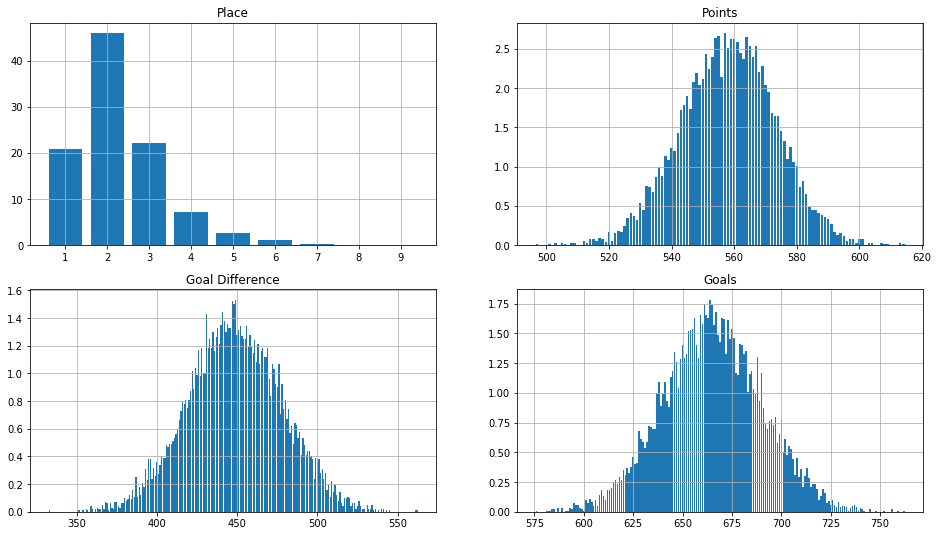

In [227]:
GoodLeague.team_report('Man City')